# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






## Подготовка данных

Задание выполнено по маленькому куску данных, дабы протестировать работоспособность кода (по всем данным за 7 часов не посчиталось ни одна эпоха).

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim
import re
import spacy

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator



SEED = 42
np.random.seed(SEED)

In [210]:
def tokenizer(text):
    return [word.lower() for word in re.findall('[a-zA-Z]+', text)]       

In [9]:
df = pd.DataFrame.from_csv('imdb_master.csv', encoding='latin-1')

In [10]:
train_df = df[df.type == 'train']
test_df = df[df.type == 'test']

In [215]:
train_df.label.value_counts()

unsup    50000
neg      12500
pos      12500
Name: label, dtype: int64

In [216]:
test_df.label.value_counts()

neg    12500
pos    12500
Name: label, dtype: int64

In [13]:
test_small = pd.concat([test_df[test_df.label == 'neg'][:200], test_df[test_df.label == 'pos'][:200]])

In [11]:
train_small = pd.concat([train_df[train_df.label == 'neg'][:200], train_df[train_df.label == 'pos'][:200],
                        train_df[train_df.label == 'unsup'][:800]])

In [14]:
train_small.to_csv(path_or_buf='train_small.csv')
test_small.to_csv(path_or_buf='test_small.csv')

In [5]:
train_df.to_csv(path_or_buf='train.csv')
test_df.to_csv(path_or_buf='test.csv')

In [3]:
classes={
    'neg': 0,
    'unsup': 1,
    'pos': 2
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

In [57]:
dataset = TabularDataset('train.csv', format='csv',
                         fields=[(("id"), None), ("type", None), ("text", TEXT), ("label", LABEL), ("file", None)], 
                         skip_header=True)

In [58]:
test_dataset = TabularDataset('test.csv', format='csv',
                         fields=[(("id"), None), ("type", None), ("text", TEXT), ("label", LABEL), ("file", None)], 
                         skip_header=True)

In [15]:
train_small_dataset = TabularDataset('train_small.csv', format='csv',
                         fields=[(("id"), None), ("type", None), ("text", TEXT), ("label", LABEL), ("file", None)], 
                         skip_header=True)

test_small_dataset = TabularDataset('test_small.csv', format='csv',
                         fields=[(("id"), None), ("type", None), ("text", TEXT), ("label", LABEL), ("file", None)], 
                         skip_header=True)

In [139]:
TEXT.build_vocab(train_small_dataset, min_freq=5)
LABEL.build_vocab(train_small_dataset)

## Задание 1

In [6]:
from gensim.models import Word2Vec

In [7]:
matrix = gensim.models.KeyedVectors.load_word2vec_format('./model/wiki-news-300d-1M.vec')

In [17]:
weights = tt.FloatTensor(matrix.vectors)

In [18]:
weights

tensor([[ 0.1073,  0.0089,  0.0006,  ...,  0.0050,  0.1173, -0.0400],
        [ 0.0897,  0.0160, -0.0571,  ...,  0.1559, -0.0254, -0.0259],
        [ 0.0004,  0.0032, -0.0204,  ...,  0.2070,  0.0689, -0.0467],
        ...,
        [ 0.0461, -0.0508, -0.1492,  ..., -0.2905, -0.0642,  0.0105],
        [-0.0907, -0.0645, -0.1101,  ..., -0.2081,  0.0312,  0.0619],
        [ 0.0855,  0.0531,  0.0040,  ..., -0.1947, -0.0116, -0.0282]])

In [38]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, way, weights=None):
        super(MyModel, self).__init__()
        if way == 'frozen': # 1
            self.embedding = nn.Embedding.from_pretrained(weights, freeze=True)
        elif way == 'notfrozen': # 2
            self.embedding = nn.Embedding.from_pretrained(weights, freeze=False)
        elif way == 'random': # 3
            self.embedding = tt.nn.Embedding(vocab_size, embed_size)
            tt.nn.init.uniform_(self.embedding.weight)
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [20]:
train_dataset_small, valid_dataset_small = train_small_dataset.split(0.7, stratified=True)

In [21]:
tt.cuda.empty_cache()

batch_size = 32

modelFroz = MyModel(len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=32,
                kernels=[2],
                way='frozen',
                weights=weights
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset_small, valid_dataset_small, test_small_dataset),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text)
)

optimizer = optim.Adam(modelFroz.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [62]:
def train_nn(model, train_iterator, validation_iterator, optimizer, scheduler, criterion, epochs):
    
    min_loss = np.inf
    no_improv_cnt = 0
    lr_history = list()
    loss_vs_epoch = {}
    patience = 5
    
    for epoch in range(epochs):
        model.train()
        val_loss_history = list()
        
        for batch in train_iterator:
            
            optimizer.zero_grad()
            pred = model.forward(batch.text[0])
            loss = criterion(pred, batch.label)
            optimizer.step()
            loss.backward()
        
        lr_history.append(optimizer.param_groups[0]['lr'])
        
        with tt.no_grad():
            for val_batch in validation_iterator:
                val_pred = model.forward(val_batch.text[0])
                val_loss = criterion(val_pred, val_batch.label)
                val_loss_history.append(val_loss)
        val_loss = np.mean(val_loss_history)
        print('epoch', epoch, 'validation loss', val_loss)
        scheduler.step(val_loss)
        
        loss_vs_epoch[epoch] = val_loss
        if val_loss < min_loss :
            min_loss = val_loss
            no_improv_cnt = 0
        elif no_improv_cnt < patience:
            no_improv_cnt += 1
        else:
            break
        
    return lr_history, loss_vs_epoch, model

In [42]:
lr_history_froz, loss_vs_epoch_froz, modelFroz = \
train_nn(modelFroz, train_iterator, valid_iterator, optimizer, scheduler, criterion, epochs=10)


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x491]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x404]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x530]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x248]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x440]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x404]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of si


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x501]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x453]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x513]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]
epoch 1 validation loss 0.87090665

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x519]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x349]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x342]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x272]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 8]
	[.text]:('[torch.LongTensor of size 8x453]', '[torch.LongTensor of size 8]')
	[.label]:[torch.LongTensor of size 8]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x352]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x513]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x396]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x311]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]
epoch 3 validation loss 0.87087387

[t


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x248]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x388]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x420]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x346]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 8]
	[.text]:('[torch.LongTensor of size 8x129]', '[torch.LongTensor of size 8]')
	[.label]:[torch.LongTensor of size 8]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x208]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 3


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x404]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x500]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x391]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x343]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x409]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x491]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of si


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x412]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x513]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x420]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x368]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x447]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x501]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of si

## Задание 2

In [45]:
modelNotFroz = MyModel(len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=32,
                kernels=[2],
                way='notfrozen',
                weights=weights
               )

In [46]:
lr_history_notfroz, loss_vs_epoch_notfroz, modelNotFroz = \
train_nn(modelNotFroz, train_iterator, valid_iterator, optimizer, scheduler, criterion, epochs=10)


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x288]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x511]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x367]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x360]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x492]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x501]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of si


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x397]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x343]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x412]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]
epoch 1 validation loss 1.0448145

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x491]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x508]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x396]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]



[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x430]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x491]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x491]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 8]
	[.text]:('[torch.LongTensor of size 8x201]', '[torch.LongTensor of size 8]')
	[.label]:[torch.LongTensor of size 8]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x328]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x516]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]
epoch 3 validation loss 1.0448145

[to


[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x440]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x381]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x430]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x513]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x391]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of size 32]
	[.text]:('[torch.LongTensor of size 32x412]', '[torch.LongTensor of size 32]')
	[.label]:[torch.LongTensor of size 32]

[torchtext.data.batch.Batch of si

## Задание 3

In [140]:
modelRand = MyModel(len(TEXT.vocab.itos),
                embed_size=300,
                hidden_size=32,
                kernels=[2],
                way='random'
               )

In [141]:
optimizer_rand = optim.Adam(modelRand.parameters())
scheduler_rand = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rand, patience=5, verbose=True, cooldown=5)
criterion = nn.CrossEntropyLoss()

In [142]:
lr_history_rand, loss_vs_epoch_rand, modelRand = \
train_nn(modelRand, train_iterator, valid_iterator, optimizer_rand, scheduler_rand, criterion, epochs=10)

epoch 0 validation loss 1.1576446
epoch 1 validation loss 1.1576446
epoch 2 validation loss 1.1576446
epoch 3 validation loss 1.1576446
epoch 4 validation loss 1.1576446
epoch 5 validation loss 1.1576446
epoch 6 validation loss 1.1576446
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.


## Plot current learning rate against number of epochs

In [33]:
import matplotlib.pyplot as plt

In [126]:
def lr_plot(epochs, lr):
    
    plt.plot([i for i in range(epochs)], lr, )
    plt.xlabel('number of epochs')
    plt.ylabel('learning rate')
    plt.title('Current learning rate against number of epochs')
    plt.show()

### Задание 1

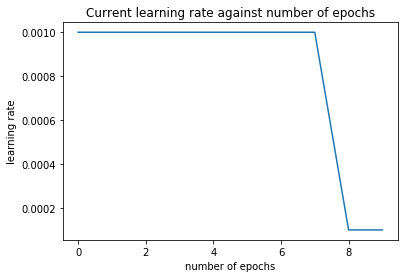

In [127]:
lr_plot(10, lr_history_froz)

### Задание 2

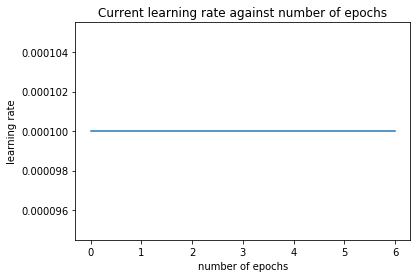

In [117]:
lr_plot(7, lr_history_notfroz)

### Задание 3

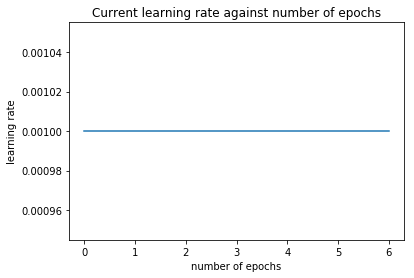

In [217]:
lr_plot(7, lr_history_rand)

## Validation curve 

In [129]:
def evaluate(model, iterator, criterion):

    loss_history = list()
    
    with tt.no_grad():
        for batch in iterator:
            
            predictions = model.forward(batch.text[0])
            loss = criterion(predictions, batch.label)
            loss_history.append(loss)
        
    return np.mean(loss_history)

In [67]:
test_loss_froz = evaluate(modelFroz, test_iterator, criterion)

In [68]:
test_loss_froz

1.5167693

In [69]:
test_loss_notfroz = evaluate(modelNotFroz, test_iterator, criterion)

In [70]:
test_loss_notfroz

1.1560915

In [144]:
test_loss_rand = evaluate(modelRand, test_iterator, criterion)

In [145]:
test_loss_rand

1.0498189

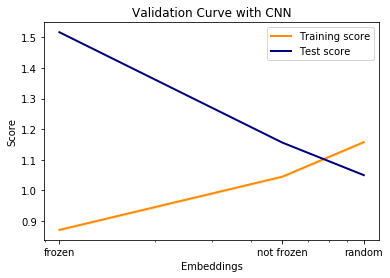

In [232]:
test_scores = [test_loss_froz, test_loss_notfroz, test_loss_rand]
train_scores = [np.mean(list(loss_vs_epoch_froz.values())), 
                np.mean(list(loss_vs_epoch_notfroz.values())), 
                np.mean(list(loss_vs_epoch_rand.values()))]

param_range = [1, 5, 9]
train_scores_mean = train_scores
train_scores_std = np.std([np.array(list(loss_vs_epoch_froz.values())), 
                           np.array(list(loss_vs_epoch_notfroz.values())), 
                           np.array(list(loss_vs_epoch_rand.values()))], axis = 1)
test_scores_mean = test_scores

plt.title("Validation Curve with CNN")
plt.xlabel("Embeddings")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores, label="Test score",
             color="navy", lw=lw)

plt.legend(loc="best")
plt.xticks([1, 5, 9], ['frozen', 'not frozen', 'random'])
plt.show()

Лучше всего на тестовой выборке сработал третий способ.